## 1 - Introduction

This Crime Data Analysis report aims to verify the accuracy of the three claims made in the "Ross Kemp and the Armed Police" documentary film, released on 6th September 2018. These claims were:

1) **Violent Crime is increasing**

2) **There are more firearms incidents per head in Birmingham than anywhere else in the UK**

3) **Crimes involving firearms are closely associated with drugs offences**

A '**Crimes Dataset**' has been obtained to aid with this report. It is a version of the **Street Level Crime Data**, which can be acquired from 'data.police.uk/', and is published by the UK Home Office, which is a compilation of crime data from January 2010 to July 2018; making it up to date with the documentary due to the two-month gap between its release and the latest data in 'Crimes'. The dataset has 12 data fields for each crime case, but only four of them are essential for this report: *Month, LSOA Code, LSOA Name, and Crime Type*.

Another dataset called '**English Indices of Deprivation (2015)**' (**EID**) is used for this report. It also contains the *LSOA Code and LSOA Name* fields, but unlike the Crimes dataset, the LSOA Names are separated into two columns: the region name and the associated 4-figure code. For example, 'Basildon 022C' is separated into Basildon and 022C. This dataset is used solely because of this feature as it makes grouping the results more convenient when there are too many variants of the same region name with different codes. 

The EID dataset also contains 37 other data fields which cover factors such as the income, employability, health, and education scores (to name a few) of numerous regions around the UK; but these are actually irrelevant to the report as the claims made by Ross Kemp have no association with said data.

The '**LSOA**', which stands for '**Lower Layer Super Output Area**', is "a geographical hierarchy designed to improve the reporting of small area statistics in England and Wales" (Lower Layer Super Output Area, 2020). The 'LSOA Code' column (field) is perhaps the most important column in both the Crimes and EID datasets as this allows for the ability to join their data together since it acts as the ID of the data, thus allowing for the data in Crimes to be linked with the region names in EID.

The approach used to verify Ross Kemp's claims involved Apache Spark in Python, an open-source, unified analytics engine used primarily for handling big data and machine learning (Apache Spark™ - What is Spark, 2020). It uses the Resilient Distributed Dataset (RDD) and DataFrames to handle data, which both allow for transformations and special actions to be carried out quickly and efficiently on the dataset, without affecting its integrity. This tool is the core of this report as the Crimes dataset has almost 47 million rows of data and it is expected that various transformations will be required in order to retrieve the appropriate data that will help determine the accuracy of Ross Kemp's claims.

The Pandas DataFrame is another tool used in this report. Its features are very similar to Spark Dataframes but it provides additional components that allow for visualisation of the data, such as plotting it on different graphs (pandas - Python Data Analysis Library, 2021). This tool is also important as the dataframes alone are not adequate enough to be able to interpret the results - especially with the amount of data some have - and graphs provide a much better, more convenient medium for presenting and viewing the data; which, in turn, makes analysis much easier.

The report has been divided into three sections or chapters: **Introduction**, **Implementation**, and **Conclusion**. The Implementation section will be the main body of the report and will have quite a few subsections as it explains the techniques and methods used to find the solution. The findings gathered from Implementation will then be collated and analysed in the Conclusion section.

# 2 - Implementation

***This entire section contains the code used to help reach the aim of this report.***

### 2.1 - Import the necessary Libraries and Packages

Import all the libraries and packages required for the assignment and create a Spark Context instance for Big Data manipulation.

In [1]:
%matplotlib inline

# Import the necessary libraries and packages for...

# ...Dataframes
import pyspark
import pandas as pd
from pandas import DataFrame
from pandas import Series

# ...Running Pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

# ...Plotting data
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

# Spark Configuration
conf = SparkConf().setMaster("local").setAppName("crimes")

# Create the Spark Context object - Try-Except block for error handling
try:
    sc = SparkContext(conf = conf)
    
    # Print the appropriate message
    print("\033[1m" + "***Creation of the Spark object was successful.***" \
          "\n***No need to run this cell again***" + "\033[0m")

except:
    # Print the appropriate message
    print("\033[1m" + "***Spark object already exists in current kernel.***" \
          "\n***No need to run this cell again***"  + "\033[0m")

# Instantiate SQL Context
sqlCtx = SQLContext(sc)

sc   # For validation that Spark Context is running

***Creation of the Spark object was successful.***
***No need to run this cell again***


<SparkContext master=local appName=crimes>

### 2.2 - Load the 'Crimes' Dataset

This is the original dataset file with headers which need to be filtered so that it does not cause issues when carrying out transformations on it. There are actually 12 columns but the last one, 'Context', is excluded as it is irrelevant and is empty for most rows.

Due to the large file size of the dataset, the 'SparkFiles' package has been imported so that it instead of saving and loading it from a local directory, the dataset can be loaded directly from its AWS S3 bucket to save time and space.

In [2]:
# Import SparkFiles so that the dataset file can be opened from AWS S3
# (via URL) instead of the local workspace (to save space)
from pyspark import SparkFiles

# URL containing the crimes dataset
url = ("https://s3.amazonaws.com/kf7032-20.northumbria.ac.uk/" \
       "all_crimes18_hdr.txt.gz")

# Add the URL into Spark Context
sc.addFile(url)

# Read the Dataset
crimes_lines = sc.textFile("file://" +
                           SparkFiles.get("all_crimes18_hdr.txt.gz"))

# Define the parseline function
def parseline(line):
    fields = line.split(',')
    Crime_ID = fields[0]
    Month = fields[1]
    Reported_By = fields[2]
    Falls_Within = fields[3]
    Longitude = fields[4]
    Latitude = fields[5]
    Location = fields[6]
    LSOA_Code = fields[7]
    LSOA_Name = fields[8]
    Crime_Type = fields[9]
    Last_Outcome_Cat = fields[10]
    
    # Return all fields
    return(Crime_ID, Month, Reported_By, Falls_Within, Longitude, Latitude,
           Location, LSOA_Code, LSOA_Name, Crime_Type, Last_Outcome_Cat)

# Instantiate the Header line and filter it out
header = crimes_lines.first()
data_only = crimes_lines.filter(lambda row:row != header)

# Apply the parseline function
crimes_data = data_only.map(parseline)

# Check the filter and check the Header line
print("Total Rows:", crimes_data.count())
print("\nHeaders:", header)

# Show the first three rows of the content RDD
crimes_data.take(3)

Total Rows: 46986836

Headers: Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context


[('',
  '2010-12',
  'Avon and Somerset Constabulary',
  'Avon and Somerset Constabulary',
  '-0.805600',
  '51.819143',
  'On or near Norfolk Terrace',
  'E01017662',
  'Aylesbury Vale 015C',
  'Other crime',
  ''),
 ('',
  '2010-12',
  'Avon and Somerset Constabulary',
  'Avon and Somerset Constabulary',
  '-2.494366',
  '51.418169',
  'On or near Keynsham Road',
  'E01014399',
  'Bath and North East Somerset 001A',
  'Anti-social behaviour',
  ''),
 ('',
  '2010-12',
  'Avon and Somerset Constabulary',
  'Avon and Somerset Constabulary',
  '-2.511927',
  '51.409435',
  'On or near Harlech Close',
  'E01014399',
  'Bath and North East Somerset 001A',
  'Anti-social behaviour',
  '')]

### 2.3 - Load the 'EID' Dataset

The process here is identical to what was used to load the Crimes dataset. 

While only the first and third columns are required, the first three have been extracted because there have been instances where some rows would get unexpected or incorrect data whenever a column in between the extracted ones has ben excluded. It seems to be an unforeseen issue with the parsing, but doing it this way reduces the risk of it occurring.

In [4]:
# Read the Dataset
EID_lines = sc.textFile("file:///home/notebookuser/Datasets/" \
                        "deprivation_with_hdr.csv")

# Define the parseline function
def EID_parseline(line):
    fields = line.split(',')
    LSOA_CODE = fields[0]
    PRE_2009_LA_CODE = fields[1]
    PRE_2009_LA_NAME = fields[2]
    
    # Return all fields
    return(LSOA_CODE, PRE_2009_LA_CODE, PRE_2009_LA_NAME)

# Instantiate the Header line and filter it out
EID_header = EID_lines.first()
EID_data_only = EID_lines.filter(lambda row:row != EID_header)

# Apply the parseline function
EID_data = EID_data_only.map(EID_parseline)

# Check the filter and check the Header line
print("Total Rows:", EID_data.count())
print("\nHeaders:", EID_header)

# Show the first five rows of the content RDD
EID_data.take(5)

Total Rows: 32482

Headers: LSOA CODE,PRE 2009 LA CODE,PRE 2009 LA NAME,POST 2009 LA CODE,POST 2009 LA NAME,GOR CODE,GOR NAME,IMD SCORE,RANK OF IMD SCORE (where 1 is most deprived),INCOME SCORE,RANK OF INCOME SCORE (where 1 is most deprived),EMPLOYMENT SCORE,RANK OF EMPLOYMENT SCORE (where 1 is most deprived),HEALTH DEPRIVATION AND DISABILITY SCORE,RANK OF HEALTH DEPRIVATION AND DISABILITY SCORE (where 1 is most deprived),EDUCATION SKILLS AND TRAINING SCORE,RANK OF EDUCATION SKILLS AND TRAINING SCORE (where 1 is most deprived),BARRIERS TO HOUSING AND SERVICES SCORE,RANK OF BARRIERS TO HOUSING AND SERVICES SCORE (where 1 is most deprived),CRIME AND DISORDER SCORE,RANK OF CRIME SCORE (where 1 is most deprived),LIVING ENVIRONMENT SCORE,RANK OF LIVING ENVIRONMENT SCORE (where 1 is most deprived),Indoors Sub-domain Score,Indoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Score,Outdoors Sub-domain Rank (where 1 is most deprived),Geographical Barriers Sub-domain Score,Geog

[('E01000001', '00AA', 'City of London'),
 ('E01000002', '00AA', 'City of London'),
 ('E01000003', '00AA', 'City of London'),
 ('E01000004', '00AA', 'City of London'),
 ('E01000005', '00AA', 'City of London')]

### 2.4 - Create Dataframes from the Datasets

To make transformations of the datasets easier, their RDDs have been converted to Dataframes. This allows for the columns to be formatted to include headers again, without the drawback of causing data type mismatch. Furthermore, it is easy to convert to Pandas dataframe for visualisation when necessary.

#### 2.4.1 - Crimes Dataset

In [5]:
# Create a dataframe of the Crimes dataset
crimes_df = sqlCtx.createDataFrame(crimes_data, ["CrimeID", "Month",
                                                 "ReportedBy",
                                                 "FallsWithin",
                                                 "Longitude", "Latitude",
                                                 "Location", "LSOACode",
                                                 "LSOAName", "CrimeType",
                                                 "LastOutcomeCategory"])

# Show this dataframe and its schema
crimes_df.show()
crimes_df.printSchema()

+-------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+-------------------+
|CrimeID|  Month|          ReportedBy|         FallsWithin|Longitude| Latitude|            Location| LSOACode|            LSOAName|           CrimeType|LastOutcomeCategory|
+-------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+-------------------+
|       |2010-12|Avon and Somerset...|Avon and Somerset...|-0.805600|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                   |
|       |2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                   |
|       |2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|On or near Harlec...|E01014399|Bath and North Ea...|Anti

#### 2.4.2 - EID Dataset

A schema with slightly different names from the original header is applied here to make the columns easier to understand as the latter was quite vague.

In [6]:
# Create a dataframe of the EID dataset
EID_df = sqlCtx.createDataFrame(EID_data, ["LSOA_Code",
                                           "Four_Figure_Code",
                                           "Region_Name"])

# Show this dataframe and its schema
EID_df.show()
EID_df.printSchema()

+---------+----------------+--------------------+
|LSOA_Code|Four_Figure_Code|         Region_Name|
+---------+----------------+--------------------+
|E01000001|            00AA|      City of London|
|E01000002|            00AA|      City of London|
|E01000003|            00AA|      City of London|
|E01000004|            00AA|      City of London|
|E01000005|            00AA|      City of London|
|E01000006|            00AB|Barking and Dagenham|
|E01000007|            00AB|Barking and Dagenham|
|E01000008|            00AB|Barking and Dagenham|
|E01000009|            00AB|Barking and Dagenham|
|E01000010|            00AB|Barking and Dagenham|
|E01000011|            00AB|Barking and Dagenham|
|E01000012|            00AB|Barking and Dagenham|
|E01000013|            00AB|Barking and Dagenham|
|E01000014|            00AB|Barking and Dagenham|
|E01000015|            00AB|Barking and Dagenham|
|E01000016|            00AB|Barking and Dagenham|
|E01000017|            00AB|Barking and Dagenham|


### CrimeType Categories

**This cell exists for the sole purpose of identifying the categories within the CrimeType column of the 'Crimes' dataset, without needing to extract them from the dataset itself.**

The list below was taken from 'www.police.uk/pu/about-police.uk-crime-data/' which covers all possible categories in the '**CrimeType**' column:

* **All crime**: Total for all categories. *DOESN'T EXIST IN DATASET*

* **Anti-social behaviour**: Includes personal, environmental and nuisance anti-social behaviour.

* **Bicycle theft**: Includes the taking without consent or theft of a pedal cycle.

* **Burglary**: Includes offences where a person enters a house or other building with the intention of stealing.

* **Criminal damage and arson**: Includes damage to buildings and vehicles and deliberate damage by fire.

* **Drugs**: Includes offences related to possession, supply and production.

* **Other crime**: Includes forgery, perjury and other miscellaneous crime.

* **Other theft**: Includes theft by an employee, blackmail and making off without payment.

* **Possession of weapons**: Includes possession of a weapon, such as a firearm or knife.

* **Public order**: Includes offences which cause fear, alarm or distress.

* **Robbery**: Includes offences where a person uses force or threat of force to steal.

* **Shoplifting**: Includes theft from shops or stalls.

* **Theft from the person**: Includes crimes that involve theft directly from the victim (including handbag, wallet, cash, mobile phones) but without the use or threat of physical force.

* **Vehicle crime**: Includes theft from or of a vehicle or interference with a vehicle.

* **Violence and sexual offences**: Includes offences against the person such as common assaults, Grievous Bodily Harm and sexual offences.

## 2.5 - Solving the Claim: 'Violent Crime is increasing'

**The next cells will cover the process and methods used to prove if this first claim was accurate.**

The plan for this is to filter the data by violent crime and then sort the results by month. The reason for this is that the claim seems to be referring to time and can be interpreted as, 'as of when this documentary was made/broadcasted, the amount of violent crime has increase in comparison to 'x' months or years ago'. Therefore, this means that **Time Series Analysis** will be involved in order to determine the accuracy of this claim.

According to (Brockwell et al. 2002), a Time Series is 'a set of observations recorded at a specific time or period of time' and that there are two types of Time Series: 'Discrete-Time', where the data is observed and recorded at fixed time intervals, and 'Continuous-Time', where the data is recorded over a period of time.

For this task, the latter will be used because the goal here is to see how the number of cases of violent crime has fluctuated over time and determine if it has increased or decreased as of 2018; the year the documentary was released.

### 2.5.1 - Filter the Data by 'Violent Crime'

As the claim specifies 'violent crime', the first task is to filter the dataset to only include data where their category of crime is considered violent.

According to the information in "CrimeType Categories", **Violence and sexual offences** is the category that is the most suitable as it specifically involves acts of crimes that directly harm people.

However, after working on Ross Kemp's third claim, it was discovered that the dataset actually includes the category '**Violent crime**' which, for unknown reasons, is not mentioned in the list of categories above. Therefore, the filter includes both 'Violent crime' and 'Violence and sexual offences' cases.

**Criminal damage and arson** seems like it could be included as it is also considered a violent act, however, its description in CrimeType Categories does not specify if the cases covered in the dataset have caused physical harm to people; directly or indirectly.

In [7]:
# Filter the dataframe to include only 'violent' crime
violent_crimes_only = crimes_df.filter((crimes_df.CrimeType ==
                                       "Violent crime") |
                                       (crimes_df.CrimeType ==
                                       "Violence and sexual offences"))

# Check if filter was successful
violent_crimes_only.show()

+-------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+-------------+-------------------+
|CrimeID|  Month|          ReportedBy|         FallsWithin|Longitude| Latitude|            Location| LSOACode|            LSOAName|    CrimeType|LastOutcomeCategory|
+-------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+-------------+-------------------+
|       |2010-12|Avon and Somerset...|Avon and Somerset...|-2.509773|51.405767|On or near Cedar ...|E01014402|Bath and North Ea...|Violent crime|                   |
|       |2010-12|Avon and Somerset...|Avon and Somerset...|-2.497371|51.412906|On or near Temple...|E01014403|Bath and North Ea...|Violent crime|                   |
|       |2010-12|Avon and Somerset...|Avon and Somerset...|-2.503260|51.410965|On or near Courtl...|E01014403|Bath and North Ea...|Violent crime|                   |
|   

### 2.5.2 - Group the Data by Month

In order to determine if violent crime HAS increased over time, the crimes dataset must first be divided/grouped into the **total number of crimes per month**.

This was done by storing the filtered crimes dataframe into a table that SQL queries can be used on, from there it was the simple case of creating a query that would count the number of times each month - with its corresponding year - appears in the dataset.

The results table was subsequently converted to Pandas dataframe to prepare it for visualisation.

In [8]:
# Create an SQL table of the crimes dataframe
violent_crimes_only.registerTempTable("Violent_Crimes")

# Count the number of violent crimes in each month
month_sql = sqlCtx.sql("SELECT Month, COUNT(*) as NumOfCrimes FROM " \
                       "Violent_Crimes GROUP BY Month ORDER BY " \
                        "Month")

# Convert the results table to Pandas dataframe
v_crimes = month_sql.toPandas()

# Check the new dataframe
v_crimes.head()

,Month,NumOfCrimes
0,2010-12,57580
1,2011-01,59823
2,2011-02,56686
3,2011-03,62326
4,2011-04,64297


### 2.5.3 - Convert the Data into a Time Series

Now that the data has been sorted, it is now ready to be converted into a Time Series dataframe. These types of dataframes typically use a Date-Time Index and are one-dimension.

As the cell below shows, the dataframe currently does not have those features, this was fixed by **converting the Months column to Date-Time format** and **setting it as the index of the dataframe**.

In [9]:
# Check the core information of the dataframe - namely the Month column
v_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        92 non-null     object
 1   NumOfCrimes  92 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


### 2.5.4 - Convert the 'Months' Column to Date-Time Format

Here, the `to_datetime()` function from Pandas is used, this function converts the given input and then parses it so that Year, Month, Day, etc. can be identified.

Since the format of the data in the Months column is '**YYYY-MM**', the 'yearfirst' parameter has been set to true to avoid any mismatch.

`info()` and `head()` are used to confirm that only the data type of Months has changed and nothing else.

In [10]:
# Convert the Month column to the appropriate datetime format
v_crimes['Month'] = pd.to_datetime(v_crimes['Month'],
                                            yearfirst=True, errors='coerce')

# Double check that the datatype of the 'Month' has changed
v_crimes.info()

# Double check the dataframe
v_crimes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        92 non-null     datetime64[ns]
 1   NumOfCrimes  92 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


,Month,NumOfCrimes
0,2010-12-01,57580
1,2011-01-01,59823
2,2011-02-01,56686
3,2011-03-01,62326
4,2011-04-01,64297


### 2.5.5 - Set the 'Months' Column as the Dataframe's Index

The `set_index()` function from Pandas DataFrame is used for this task; where the Month is the input. By default, this function modifies the index and places the input back as it was in the Dataframe, this is not the desired output though as the Time Series needs to be one-dimensional. So the 'inplace' parameter has been invoked and set to true to remove the input column altogether since it is now the index.

In retrospect, it may have been more convenient to do both this transformation and the previous one in the same cell, however, the purpose of separating them was to ensure that each step worked properly.

`info()` and `head()` are used at the end again, this time to confirm that the index has been modified and that Months is no longer a 'column'.

In [11]:
# Set the Months column to be the index of the dataframe
v_crimes.set_index('Month', inplace=True)

# Double check again to see if the index has changed
v_crimes.info()
v_crimes.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2010-12-01 to 2018-07-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   NumOfCrimes  92 non-null     int64
dtypes: int64(1)
memory usage: 1.4 KB


,NumOfCrimes
Month,
2010-12-01,57580
2011-01-01,59823
2011-02-01,56686
2011-03-01,62326
2011-04-01,64297


### 2.5.6 - Extract the NumOfCrimes Column from the Dataframe

This step is necessary for the Stacked Line Plot Graph because the data needs to be one-dimensional. Using the normal 'v_crimes' dataframe raises an Exception error because even though the 'Months' column has been set as its index, it is still interpreted as another column, thus making it two-dimensional.

The column is already a series of Integer values so it does not require the Pandas `to_numeric()` function.

In [12]:
# Extract the 'NumOfCrimes' column in a new variable
v_crimes_num = v_crimes['NumOfCrimes']

# Check it
v_crimes_num

Month
2010-12-01     57580
2011-01-01     59823
2011-02-01     56686
2011-03-01     62326
2011-04-01     64297
               ...  
2018-03-01    140964
2018-04-01    142115
2018-05-01    158058
2018-06-01    156091
2018-07-01    166576
Name: NumOfCrimes, Length: 92, dtype: int64

### 2.5.7 - Plot the data for Analysis

The data has been plotted as a Line plot and a Whisker and Box plot to provide various perspectives of the results. These methods of visualisation are used as they both present the trends in the data in a simple and easy to understand manner. The line graph shows fluctuations in the data, the whisker and box plot shows the highest and lowest values of each year, while both show the overall increase and decrease of the results.

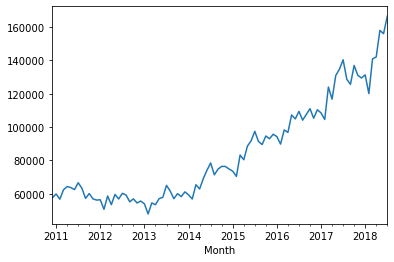

In [13]:
# Plot the data as Line Graph
v_crimes_num.plot()
pyplot.show()

For the Whisker and Box plot, the data needed to be reorganised so that each row is a month ranging from January to December, and each column is a year. This way, the graph will actually show the boxes for each year and not just one for the whole Time Series. This was done by creating a new Dataframe and using the `Grouper()` function from Pandas as it is able to parse the Date-Time index of the Time Series sort the data by years and its months.

Notice that the boxplot excludes all data from 2018, this is because the iterator which fills the new dataframe has automatically set the length of each row to 12 columns since the first year in the Time Series (2010) has a full 12 months of data. But because the data from 2018 only covers up to July, it causes a error since its total length is not the same as the preset length.

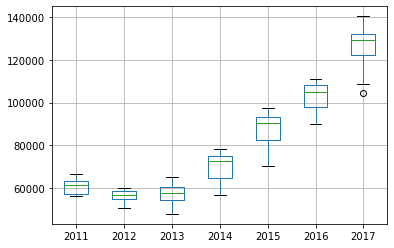

In [14]:
# Instantiate the groups and a new dataframe
groups = v_crimes_num.groupby(pd.Grouper(freq="A"))
v_crimes_years = DataFrame()

# Split the time series into groups (years) and insert into dataframe
for name, group in groups:
    if len(group.values) == 12: # Exclude years that do not have full 12 months
        v_crimes_years[name.year] = group.values

# Present data as whisker and box plot
v_crimes_years.boxplot()
pyplot.show()

## 2.6 - Solving the Claim: 'There are more Firearms incidents per head in Birmingham than anywhere else in the UK'

**The next cells will cover the process and methods used to prove if the second claim was true.**

The objectives for this task are straightforward, the data will need to be **filtered to show only firearms-related crimes**, then **combined and arranged according to region**, and finally, **plotted on a graph**. The results on said graph will help determine if this claim is accurate.

### 2.6.1 - Filter the Data by Firearms-related crimes

The process here is similar to the one used for solving the first claim, the `filter()` function from Spark is used again to extract the appropriate data.

According to the information in "CrimeType Categories", there is a category named **Possession of weapons**, so this will be used for the filter.

In [15]:
# Filter the dataframe to cover only firearms-related data
firearms_only = crimes_df.filter(crimes_df.CrimeType ==
                                 "Possession of weapons")

# Review the filtered data
firearms_only.take(5)

[Row(CrimeID='9c68ace1c9a77a7f4ee78fcb39195373f48bef29a21a761de0b7f0f3c1acf966', Month='2013-05', ReportedBy='Avon and Somerset Constabulary', FallsWithin='Avon and Somerset Constabulary', Longitude='-2.351833', Latitude='51.398435', Location='On or near Bay Tree Road', LSOACode='E01014410', LSOAName='Bath and North East Somerset 004B', CrimeType='Possession of weapons', LastOutcomeCategory='Offender given a caution'),
 Row(CrimeID='05c3e05b387d09ced2a8e789d84ed35246800f16d7befb9a3042d488008905bb', Month='2013-05', ReportedBy='Avon and Somerset Constabulary', FallsWithin='Avon and Somerset Constabulary', Longitude='-2.365540', Latitude='51.388682', Location='On or near Harley Street', LSOACode='E01033080', LSOAName='Bath and North East Somerset 009E', CrimeType='Possession of weapons', LastOutcomeCategory='Offender given community sentence'),
 Row(CrimeID='86a6b4fa4cd29514421b11764215dc1413c8a1937d46af24ec8ec3358ee75819', Month='2013-05', ReportedBy='Avon and Somerset Constabulary', Fa

### 2.6.2 - Before the Data can be arranged by Region...

Now that the data contains only the cases of firearms-related crime, the remaining task is to arrange it by region name. However, because the region names in the 'LSOAName' column of the Crimes dataset have a 4-figure code at the end, it would be impractical to use that for sorting as there are too many variations of the same region with different codes. Instead, the 'Region_Name' column from the EID dataset will be used since it consists of just the region names and no code.

Therefore, additional steps must be taken in order to be able to arrange the data by region. Conveniently, the EID dataset also has an LSOA code column which will allow it to be joined with the firearms_only data through its own LSOA code column.

### 2.6.3 - Extract the LSOA Code from the filtered Data

Only the data in the 'LSOACode' column is required from the firearms_only filtered data since it acts like the ID of the rows of data and it will be used for counting the number of firearms-related crimes in the different regions.

The filtered dataframe was saved as an SQL table the column, extracted using SQL queries since the dataframe includes other columns not required for this task. It could have been extracted using `firearms_only['LSOACode]` but the `show()` function cannot call a single column.

In [16]:
# Create an SQL table of the filtered dataframe
firearms_only.registerTempTable("firearms_cases")

# Extract the LSOA codes from this table
firearms_lsoa = sqlCtx.sql("SELECT LSOACode FROM firearms_cases")

# Check if query was successful
print('Total Number of Rows:', firearms_lsoa.count())
firearms_lsoa.show()

Total Number of Rows: 159023
+---------+
| LSOACode|
+---------+
|E01014410|
|E01033080|
|E01014602|
|E01014638|
|E01014636|
|E01014642|
|E01014618|
|E01014508|
|E01014624|
|E01014629|
|E01014485|
|E01014489|
|E01014551|
|E01014531|
|E01014536|
|E01014581|
|E01014655|
|E01014655|
|E01029034|
|E01029047|
+---------+
only showing top 20 rows



### 2.6.4 - Extract the LSOA Code and Region Name columns from the EID Data

The 'LSOA_Code' column from the EID dataset is used solely as a means to join it with the firearms-filtered dataframe, while the 'Region_Name' is the important one as it will allow for the data to be counted and grouped by it.

Here, the columns are extracted via column name instead of SQL queries as it is the more convenient method in this situation.

In [17]:
# Extract the LSOA code and region name columns from EID dataframe
EID_lsoa = EID_df['LSOA_Code', 'Region_Name']

print('Total Number of Rows:', EID_lsoa.count())
EID_lsoa.show()

Total Number of Rows: 32482
+---------+--------------------+
|LSOA_Code|         Region_Name|
+---------+--------------------+
|E01000001|      City of London|
|E01000002|      City of London|
|E01000003|      City of London|
|E01000004|      City of London|
|E01000005|      City of London|
|E01000006|Barking and Dagenham|
|E01000007|Barking and Dagenham|
|E01000008|Barking and Dagenham|
|E01000009|Barking and Dagenham|
|E01000010|Barking and Dagenham|
|E01000011|Barking and Dagenham|
|E01000012|Barking and Dagenham|
|E01000013|Barking and Dagenham|
|E01000014|Barking and Dagenham|
|E01000015|Barking and Dagenham|
|E01000016|Barking and Dagenham|
|E01000017|Barking and Dagenham|
|E01000018|Barking and Dagenham|
|E01000019|Barking and Dagenham|
|E01000020|Barking and Dagenham|
+---------+--------------------+
only showing top 20 rows



### 2.6.5 - Join the Firearms Data with the EID Data

Finally, join the two dataframes by their respective LSOA code columns, thus assigning the LSOA codes from Crimes with the appropriate region names from EID.

Pyspark SQL functions are used instead of query strings because it is more straightforward to code.

In [18]:
# Join firearms_cases with EIDTable on LSOA code
firearms_EID_join = firearms_lsoa.join(EID_lsoa,
                                       firearms_lsoa.LSOACode ==
                                       EID_lsoa.LSOA_Code)

print('Total Number of Rows:', firearms_EID_join.count())
firearms_EID_join.show()

Total Number of Rows: 133644
+---------+---------+--------------------+
| LSOACode|LSOA_Code|         Region_Name|
+---------+---------+--------------------+
|E01000078|E01000078|Barking and Dagenham|
|E01000078|E01000078|Barking and Dagenham|
|E01000078|E01000078|Barking and Dagenham|
|E01000078|E01000078|Barking and Dagenham|
|E01000078|E01000078|Barking and Dagenham|
|E01000078|E01000078|Barking and Dagenham|
|E01000078|E01000078|Barking and Dagenham|
|E01000138|E01000138|              Barnet|
|E01000138|E01000138|              Barnet|
|E01000622|E01000622|               Brent|
|E01000622|E01000622|               Brent|
|E01000622|E01000622|               Brent|
|E01000622|E01000622|               Brent|
|E01000622|E01000622|               Brent|
|E01000781|E01000781|             Bromley|
|E01000781|E01000781|             Bromley|
|E01000975|E01000975|             Croydon|
|E01000975|E01000975|             Croydon|
|E01000975|E01000975|             Croydon|
|E01000975|E01000975|    

### 2.6.6 - Arrange the Data by Region

Now it is possible to arrange the data by region name and acquire the desired results. Pyspark SQL functions are also used for grouping and sorting as, once again, it is faster to code.

The results are immediately converted to pandas dataframe and the column names are changed slightly to prepare it for visualisation. Additionally, they have been sorted in descending order so that the ones with the largest value will be first. **The reasoning for this is explained in the plotting of this data.**

In [19]:
# Group by region name using Pyspark SQL methods
firearms_df = firearms_EID_join.groupBy("Region_Name").count() \
                               .sort("count", ascending=False).toPandas()

# Rename the column names to prepare for plotting
firearms_df.columns = ["RegionName", "TotalFirearmsCases"]

# Check if the transformations were successful
firearms_df

,RegionName,TotalFirearmsCases
0,Birmingham,3051
1,Manchester,2655
2,Uttlesford,2540
3,Leeds,1804
4,Sheffield,1674
...,...,...
349,Teesdale,24
350,Rutland,23
351,Ribble Valley,23
352,West Somerset,17


### 2.6.7 - Plot the Data

**Plot the top 10 regions with the largest number of firearms incidents**.

The results are plotted on a simple horizontal bar chart as it presents the results much more clearly than something like a line graph. 

Only the first 10 results are plotted as it seemed impractical to include all 354 regions because then its labels would be incomprehensible and/or there would be too much unnecessary data on the graph.

Additionally, the second claim states that '**Birmingham**' has the most crime related to firearms, which implies that it would be **the region with the largest value of these results if it was true**, thus suggesting that attention should be focused only at the data within the "top-ten" range.

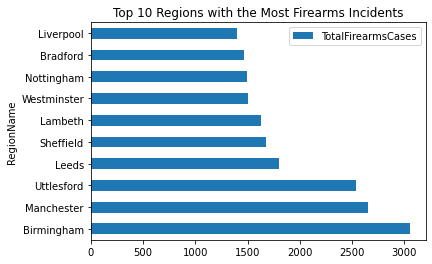

In [20]:
# Plot the data as Line Graph
firearms_df.head(10).plot.barh(x='RegionName', y='TotalFirearmsCases',
                               title="Top 10 Regions with the Most " \
                               "Firearms Incidents")

pyplot.show()

## 2.7 - Solving the Claim: 'Crimes involving firearms are closely associated with drugs offences'

**These next cells will cover the process and methods used to prove if the third and final claim was true.**

This claim implies that there is a **positive correlation** between cases related to firearms and drugs, therefore, it has been determined that the data will need to be plotted on to a scatter matrix as it is the best medium to use for visualising correlations. Furthermore, in order to ensure that the data and its results are unbiased, all data from all categories of CrimeType should be included and not just firearms and drugs so that the scatter matrix will show how ALL of them correlate with each other.

Most of the processes and methods used for this problem have been recycled from the problem regarding the previous claim. This is because the data will need to be collated by region again so that the total for each given region and crime type can be found, and then plotted on the scatter matrix. This means that, as before, the 'LSOA code' columns are the key again. 

The tasks for this problem are quite similar to the previous one: **extract data from the appropriate columns**, **arrange it by region name**, and **plot the results as a scatter matrix** to show correlations.

### 2.7.1 - Extract the LSOACode and CrimeType columns from the Crimes Dataset

This was done simply by calling the column names. No SQL table or query is required here since there is no filtering involved.

In [21]:
# Extract the required data
crimes_lsoa = crimes_df['LSOACode', 'CrimeType']
crimes_lsoa.show()
print('Total rows:', crimes_lsoa.count())

+---------+--------------------+
| LSOACode|           CrimeType|
+---------+--------------------+
|E01017662|         Other crime|
|E01014399|Anti-social behav...|
|E01014399|Anti-social behav...|
|E01014399|Anti-social behav...|
|E01014399|Anti-social behav...|
|E01014399|Anti-social behav...|
|E01014399|            Burglary|
|E01014399|            Burglary|
|E01014399|         Other crime|
|E01014400|Anti-social behav...|
|E01014400|Anti-social behav...|
|E01014400|Anti-social behav...|
|E01014400|Anti-social behav...|
|E01014400|Anti-social behav...|
|E01014400|Anti-social behav...|
|E01014400|            Burglary|
|E01014400|            Burglary|
|E01014400|            Burglary|
|E01014400|            Burglary|
|E01014400|       Vehicle crime|
+---------+--------------------+
only showing top 20 rows

Total rows: 46986836


### 2.7.2 - Join the All Crimes Data with the EID Data

The same joining method used as part of solving the second claim is used here as well. Also, since the EID_lsoa has already been instantiated in a previous cell there is no need to do so here.

In [22]:
# Join the crimes and previously made EID tables
crimes_EID_join = crimes_lsoa.join(EID_lsoa,
                                   crimes_lsoa.LSOACode ==
                                   EID_lsoa.LSOA_Code)

crimes_EID_join.show()
print('Total rows:', crimes_EID_join.count())

+---------+--------------------+---------+--------------------+
| LSOACode|           CrimeType|LSOA_Code|         Region_Name|
+---------+--------------------+---------+--------------------+
|E01000078|Anti-social behav...|E01000078|Barking and Dagenham|
|E01000078|             Robbery|E01000078|Barking and Dagenham|
|E01000078|       Violent crime|E01000078|Barking and Dagenham|
|E01000078|       Violent crime|E01000078|Barking and Dagenham|
|E01000078|       Violent crime|E01000078|Barking and Dagenham|
|E01000078|       Violent crime|E01000078|Barking and Dagenham|
|E01000078|       Violent crime|E01000078|Barking and Dagenham|
|E01000078|       Violent crime|E01000078|Barking and Dagenham|
|E01000078|       Violent crime|E01000078|Barking and Dagenham|
|E01000078|         Other crime|E01000078|Barking and Dagenham|
|E01000078|Anti-social behav...|E01000078|Barking and Dagenham|
|E01000078|Anti-social behav...|E01000078|Barking and Dagenham|
|E01000078|Anti-social behav...|E0100007

### 2.7.3 - Arrange the Data by Region Name and Crime Type

Now that the necessary data has been extracted and joined, it can be organised so that the Region_Name and CrimeType columns are in alphabetical order. Pyspark SQL functions were used to keep the code relatively short. The resulting 'Crimes EID' dataframe was immediately stored as a Pandas dataframe to prepare it for visualisation.


#### An issue with this Dataframe...

Currently, the dataframe holds all the categories of CrimeType (crime types) under one column and has over 5,000 rows, which is not suitable for plotting on a scatter matrix since the crime types cannot be identified like this and it only allows for numerical data.

Ideally, the dataframe should have **the crime types assigned a column each**, that way the number of rows will be **reduced to the total number of unique regions**, all data within will be numbers only. With this layout, it would be possible to identify which data point belongs to which specific region and crime type.

The aforementioned 'ideal' dataframe is constructed in a later cell and it was for this purpose that the 'Region_Name' and 'CrimeType' columns were sorted in alphabetical order as it makes it easier for the data to be inserted into the correct row and column of said dataframe.

In [23]:
# Count the number of unique results and convert to Pandas dataframe
crimes_EID_df = crimes_EID_join.groupBy("Region_Name", "CrimeType") \
                               .count().orderBy("Region_Name",
                                                "CrimeType").toPandas()

# Change the column names
crimes_EID_df.columns = ["RegionName", "CrimeType", "TotalCases"]
crimes_EID_df

,RegionName,CrimeType,TotalCases
0,"""Bristol",Anti-social behaviour,119417
1,"""Bristol",Bicycle theft,5628
2,"""Bristol",Burglary,30098
3,"""Bristol",Criminal damage and arson,28410
4,"""Bristol",Drugs,7158
...,...,...,...
5658,York,Shoplifting,8245
5659,York,Theft from the person,597
5660,York,Vehicle crime,5869
5661,York,Violence and sexual offences,12824


### 2.7.4 - Prepare the layout of the new 'Ideal' Dataframe

A few preliminary steps must be taken to ensure that the new dataframe has the desired layout, which are to: **Prepare the header names** and **set the size of the dataframe**.

### 2.7.4.1 - Prepare the Header Names

As mentioned in a previous cell, the columns in the new dataframe should be the different crime types. Therefore, the CrimeType column has been  extracted from the 'crimes_EID_join' dataframe and grouped by the CrimeType column to show the different categories of crime; whilst making sure to sort them in alphabetical order so as to avoid causing any data mismatch when it is finally inserted into the new dataframe.

The results were subsequently converted to a list for the new dataframe's columns and also so that an extra column for the region name could be added to the front.

In [24]:
# Extract the crimetype categories 
numOfCrimeTypes = crimes_EID_join.select("CrimeType") \
                                 .groupBy("CrimeType").count() \
                                 .orderBy("CrimeType")

# Extract the CrimeType headers as a list
crimetype_col = numOfCrimeTypes.toPandas()
crimetype_list = crimetype_col['CrimeType'].tolist()

# Insert 'Region Name' to the front of the list
crimetype_list.insert(0, 'Region Name')

# Check the list
crimetype_list

['Region Name',
 'Anti-social behaviour',
 'Bicycle theft',
 'Burglary',
 'Criminal damage and arson',
 'Drugs',
 'Other crime',
 'Other theft',
 'Possession of weapons',
 'Public disorder and weapons',
 'Public order',
 'Robbery',
 'Shoplifting',
 'Theft from the person',
 'Vehicle crime',
 'Violence and sexual offences',
 'Violent crime']

### 2.7.4.2 - Set the Size of the Dataframe

The initial plan for this part was to use the size of Crimes EID dataframe as the size of the new dataframe since they are both basically the same dataframe, just with different columns.

However, an issue with this method was discovered upon further testing and analysis of the new dataframe, where if a region did not have any data for a given crime type, the dataframe constructor would end up filling its equivalent column with data from the next crime type instead of a 0 or null value; thus causing a mismatch of data.

This problem was fixed after making alterations to the dataframe constructor (shown in a later cell), but this led to another problem because **the size of the Crimes EID dataframe was not enough to compensate for rows with missing values**.

Therefore, it was decided that the size of the dataframe should instead be based on the **number of CrimeType categories** MULTIPLIED by the **number of different regions**, as this represents the full data without any missing values. And so, the task was changed to identify what those dimensions are.

For the crime types, since they were already extracted for the header, it was just the simple case of getting its `count()` value. The full header list **was not** used here because that includes the 'Region Name' header, which not involved with CrimeType.

For the region names, the full EID data was grouped by the 'Region_Name' name column and then counted using the same function to get the total number of sorted rows. `count()` is used twice because the first one is required finish grouping the results and the second, to count the number of results.

In [25]:
# Number of CrimeType categories
ct_num = numOfCrimeTypes.count()
print('Number of CrimeType Categories:', ct_num)

# Number of unique regions
rgn_num = EID_df.groupBy('Region_Name').count().count()
print('Number of Regions:', rgn_num)

Number of CrimeType Categories: 16
Number of Regions: 354


### 2.7.5 - Create the 'Ideal' Dataframe

The code below contains the constructor for the new dataframe, '**Crimes (by) Region**'. The basic concept of this constructor is that it iterates through the Crimes EID dataframe, extracts the data from 'TotalCrimes' and inserts it into the appropriate row and column in the new dataframe.

To ensure that it inserts data in the correct row, it checks the 'Region Name' of the current index of the Crimes EID dataframe and compares it with the region name in the current row of this new dataframe. If they are the same then the constructor continue adding data in the that row, otherwise it will move to the next row and repeat from there. **This is shown in lines 14 to 17**.

For the columns, it takes the crime type of the current row from Crimes EID and compares it with the current column header of 'Crimes by Region'. If they are the same then the corresponding data from 'TotalCrimes' will be inserted; otherwise it will 'pause' at the counter of 'TotalCrimes' and insert a zero instead. **As shown in lines 25 to 32**.

The latter part fixes the issue mentioned in **Section 2.7.4.2**, as this ensures that any region which does not have any data for a given crime type is still taken into account and that the equivalent position for it in 'Crimes by Region' is still given a value; thus mitigating the possibility of mismatched data. Additionally, there is no risk of data intended for the current row to overflow to the next one since the counter for the column header 'k' is reset every time the region name changes, and the counter for 'TotalCrimes' only increments when the crime types are the same; as shown in **lines 14 and 32** respectively.

In [26]:
# Prepare the new dataframe for the crimes and regions data
crimes_regions = DataFrame(columns=crimetype_list)

current_name = ''   # Current region name
n = 0   # Counter for 'crimes_EID_df' index
j = 0   # Counter for 'crimes_regions' index
k = 1   # Counter for 'crimetype_list' index

# Iterate through the dataframe (if it had no missing values)
for i in range(rgn_num * ct_num):

    # Compare the region name of previous and current index and
    # update variables accordingly if conditions are met
    if current_name != crimes_EID_df.RegionName[n]:
        current_name = crimes_EID_df.RegionName[n]
        j += 1
        k = 1

    # Insert the current region name into the specified row and column
    crimes_regions.loc[j, 'Region Name'] = current_name

    # If value for current column does not exist, insert a zero...
    if crimes_EID_df.CrimeType[n] != crimetype_list[k]:
        crimes_regions.loc[j, crimetype_list[k]] = 0

    # ...Otherwise just insert values normally
    else:
        crimes_regions.loc[j, crimetype_list[k]] = crimes_EID_df.TotalCases[n]
        n += 1

    # Increment crimetype_list counter
    k += 1
    
#END FOR-LOOP

# Preview the dataframe
crimes_regions

,Region Name,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public disorder and weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences,Violent crime
1,"""Bristol",119417,5628,30098,28410,7158,18158,28384,743,179,16560,3074,22058,2150,27083,49028,15922
2,"""Herefordshire",54473,1053,7517,8871,3137,6010,9587,407,698,2420,308,5101,440,4556,17331,4844
3,"""Kingston upon Hull",56571,5183,27205,27943,4919,14527,20414,757,1703,6995,1987,18226,1076,15373,38043,10322
4,Adur,13848,498,2275,3575,941,1897,2622,160,176,1236,150,1310,175,2009,5201,1320
5,Allerdale,25634,247,3584,7823,1868,3192,3914,171,366,1567,91,3621,134,2217,8379,2406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Wychavon,28443,442,6235,5735,1383,3191,5952,178,232,1149,234,3100,264,5246,9582,2153
351,Wycombe,17765,610,6626,8570,2367,5066,10499,391,503,1353,648,5550,904,6870,10402,3515
352,Wyre,35071,686,4511,6425,959,2970,5464,97,236,893,179,3291,227,3637,8878,2602
353,Wyre Forest,35679,496,5937,6323,1510,4287,5609,285,400,1422,347,5158,311,6100,11337,3702


In [27]:
# Show the core information of the dataframe
crimes_regions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 1 to 354
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Region Name                   354 non-null    object
 1   Anti-social behaviour         354 non-null    object
 2   Bicycle theft                 354 non-null    object
 3   Burglary                      354 non-null    object
 4   Criminal damage and arson     354 non-null    object
 5   Drugs                         354 non-null    object
 6   Other crime                   354 non-null    object
 7   Other theft                   354 non-null    object
 8   Possession of weapons         354 non-null    object
 9   Public disorder and weapons   354 non-null    object
 10  Public order                  354 non-null    object
 11  Robbery                       354 non-null    object
 12  Shoplifting                   354 non-null    object
 13  Theft from the perso

### 2.7.6 - Change the Datatype of the new Dataframe

As seen in the cell above, the datatype of the crime types are 'object' types, which cannot be plotted on a scatter matrix. This was fixed simply by using the `astype()` function associated with Pandas dataframes and setting it to the appropriate Integer type so that the dataframe now has true numerical data.

In [28]:
# Extract the crime-related columns and convert its dtype to 'Integer'
ct_int = crimes_regions[crimes_regions.columns[1:]].astype('int64')
ct_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 1 to 354
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Anti-social behaviour         354 non-null    int64
 1   Bicycle theft                 354 non-null    int64
 2   Burglary                      354 non-null    int64
 3   Criminal damage and arson     354 non-null    int64
 4   Drugs                         354 non-null    int64
 5   Other crime                   354 non-null    int64
 6   Other theft                   354 non-null    int64
 7   Possession of weapons         354 non-null    int64
 8   Public disorder and weapons   354 non-null    int64
 9   Public order                  354 non-null    int64
 10  Robbery                       354 non-null    int64
 11  Shoplifting                   354 non-null    int64
 12  Theft from the person         354 non-null    int64
 13  Vehicle crime                 354 n

### 2.7.7 - Plot the Data as a Scatter Matrix

The scatter matrix plotter used is from the 'plotting' package from Pandas. The size of the figure was set as such so that the entire graph - and just enough of the labels on the X-axis - is visible on the screen (without having to scroll).

The scatter matrix was used to plot the results, as it is one of the most optimal visualisation tools for identifying the correlations between all numerical data in a dataframe.

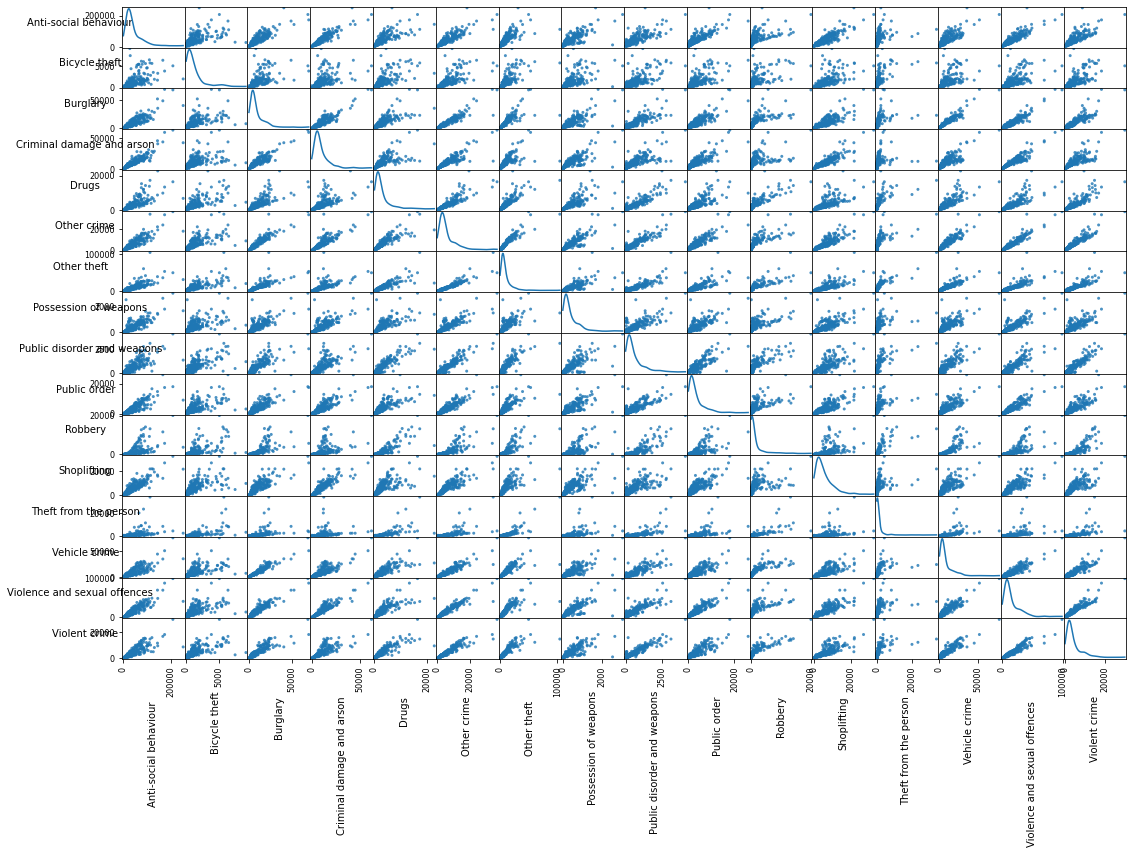

In [29]:
# Present data as scatter matrix
sm = scatter_matrix(ct_int, alpha=0.8, figsize=(18, 12), diagonal='kde')

# Change orientation of the labels
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

pyplot.show()

### 2.7.8 - Plot data as a Seaborn Plot

Seaborn is a library used for making statistical graphics based on 'matplotlib', with the added bonus of integration with Pandas Dataframes (Waskom, 2020).

While the scatter matrix above already shows the correlations between all columns, this Seaborn regression plot '`regplot()`' was included to provide a more detailed view of correlation between two specified columns, since the individual plots of the latter seem quite small. Furthermore, this type of plot includes additional features that further enhance the presentation of the data, such as the regression line, which in this case can be interpreted as the correlation line, and the confidence interval of the results.

To view a correlation between two specific columns, simply change the `ct1` and `ct2` variables to the desired column headers.

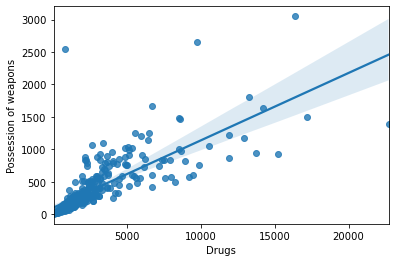

In [30]:
# Import the Seaborn library
import seaborn as sns

# Set these variables to different CrimeType categories
ct1 = 'Drugs'
ct2 = 'Possession of weapons'

# Seaborn plot to get the trend line
sb_plot = sns.regplot(x= ct1, y=ct2, data = (ct_int[[ct1, ct2]]))

## 3 - Conclusion

**Disclaimer**: It must be addressed that the EID dataset covers 354 different regions but it is unknown how many regions are actually covered in the Crimes dataset. However, from the joins made between them, it has been noticed that the resulting dataframes (before being sorted by region name) consistently show a slightly lesser number of rows than the total of different LSOA codes in the Crimes dataset; as shown in **cells 2.7.1 and 2.7.2**. From this, it is clear that the amount of regions covered in the EID dataset is quite insufficient but fortunately, not enough to drastically affect the results.

### Violent Crime is increasing

Gathering from the results shown in the line graph and whisker and box graph plotted from the 'Violent Crimes Time Series', it can be stated with confidence Ross Kemp's claim was true, violent crime has definitely increased. In fact, it was much higher than in any of the years the last decade (relative to 2018), and the months leading up to 2018 had the highest average of violent crime cases.

### There are more firearms incidents per head in Birmingham than anywhere else in the UK

The bar chart plotted from the Firearms dataframe reveals that this statement of Ross Kemp is true, as it shows that Birmingham DOES have the most cases of firearms incidents in the UK; with approximately 500 - 600 more cases than the region with the second highest number of firearms incidents. However, as mentioned in the disclaimer the results do not cover all possible regions in the UK, which could mean that there is a possibility that the bar chart will show different results depending on how many regions are missing.

### Crimes involving firearms are closely associated with drugs offences

The results on the 'Crimes by Region' scatter matrix and the 'Drugs and Possession of Weapons' regression plot both show that this claim could be considered true as it shows that crimes related to firearms have a correlation to those related drugs. However, a possible interpretation of the claim is that "the relation between drugs offences and firearms incidents is much closer than other crime types". If this was what Ross Kemp implied, then his claim would be considered as neither true nor false because while the results *do* show that drugs offences and firearms incidents are closely related to each other, it does not explicitly show that they are the *only* ones with such as a relation; the scatter matrix shows that almost all crime types have a strong positive correlation with each other.

Overall, the claims made by Ross Kemp regarding crime in the UK are accurate, as the results made in this report provide evidence of this. The datasets used to help produce said results were of great value as the amount of data within were more than enough to prove or disprove the claims, even if the EID dataset did not cover all possible regions in the Crimes dataset. As for the techniques used, there are many methods available for caryring out the tasks in the report, but the ones that *were* used proved to be good enough to retrieve and compile the required data.

### References

Brockwell, P.J., Davis, R.A. and Calder, M.V., 2002. Introduction to time series and forecasting (Vol. 2, pp. 3118-3121). New York: springer.

Databricks. 2020. Apache Spark™ - What Is Spark. [online] Available at: https://databricks.com/spark/about [Accessed 29 December 2020].

Datadictionary.nhs.uk. 2020. Lower Layer Super Output Area. [online] Available at: <https://datadictionary.nhs.uk/nhs_business_definitions/lower_layer_super_output_area.html> [Accessed 2 January 2021].

Pandas.pydata.org. 2021. Pandas - Python Data Analysis Library. [online] Available at: <https://pandas.pydata.org/> [Accessed 3 January 2021].

Waskom, M., 2020. An Introduction To Seaborn — Seaborn 0.11.1 Documentation. [online] Seaborn.pydata.org. Available at: <https://seaborn.pydata.org/introduction.html> [Accessed 4 January 2021].